# INTRODUCTION
This project is about developing a model that automatically make corrections on neural machine translations. It is called an Automatic Post-Edit Model (APE). The model was purely research based and was developed from the scratch and trained on a well-known dataset.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Layer
import keras
from keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping

from tensorflow.keras.layers.experimental import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer as Vectorizer
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
import re
import unicodedata
import os
import numpy as np
from time import time

file_path  = '/content/drive/MyDrive/Deep Learning/APE'
os.chdir(file_path)

In [ ]:
pip install tensorflow_text

     |████████████████████████████████| 4.4 MB 5.3 MB/s 


In [ ]:
import tensorflow_text as tf_text



# Project Sections

This project is divided into sections as follows:

- Model creation

- Preprocessing training data

- Train of Generic model and Evaluation (using BLEU and TER)

- Online Learning 

- Conclusion


Check current folder (google drive link) for all research papers used in this notebook. Please, also make sure to change runtime type to GPU from the 'Runtime' tab above before running this notebook.

## Model Development

This model is implemented from a research paper by Chatterjee et al 2017a. The model receives the (src,mt) as input and attempts to predict the human post editing correction (hpe).

### Summary of Model
It uses an encoder-decoder model to learn. The encoder takes the src and mt sentences, encodes them separately using a GRU model. Then passes this encoded src and mt to the decoder as a tuple.
It also passes its hidden state to the decoder. This hidden state is used to initialize the decoder's hidden state.

The decoder takes the previous word in the sentence, its previous hidden state, encoded src , encoded mt as inputs. The decoder consists of 2 GRU models. First, it concatenates its previous hidden state and the previous word after embedding it (representing each word as unique vectors) together and passes this concatenated vector through the first GRU to get an intermediate hidden state. The decoder then initializes two attention (Badhanau attention) mechanisms and uses both to attend to the encoded src and mt. 

This attention basically weights each word in the src and mt using the intermediate hidden state. So relevant words for a time step t will be weighted more than irrelevant words.

It attends to its encoded inputs separately using the intermediate hidden state as a query to produce context vector s for src and context vector m for mt. These two contexts are then merged and linearly transformed using a dense layer to produce the final context vector v.

It then concatenates this context vector v and the intermediate hidden state and passes the result to the second GRU to produce a final hidden state. This hidden state is then passed to a dense layer (fully connected layer) to produce the probability of the next target word in the human post edited sentence. It uses a loop for training (customized training).


"*The strict connection between MT errors and the input source sentences suggests to develop APE systems that leverage information both from the source (src) and it’s corresponding translation (mt) instead of looking at the machine-translated sentence in isolation. Exploiting source information as an additional input can in fact help the system to disambiguate corrections applied at each time step. For example, the German phrase “mein Haus” (EN: my house) looks correct but if the source phrase was “my home” then the correct
translation would be “mein Zuhaus”. In this case,an APE system ignoring the source would have left the sub-optimal MT output untouched.*" - Chatterjee et al 2017a


### Model Creation

In the creation of the models, variables were reused to manage resources (RAM) during training.


In [ ]:
# First, we define the attention class. It was implemented from the Bahdanau et al 2014 research paper on attention mechanism.

class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

   

  def call(self, enc_hidden, dec_inter_hidden):
    # hidden here means 'hidden_size', word length the same as 'sentence length'
    # enc_hidden shape == (batch_size, word_length, hidden)
    # dec_inter_hidden shape == (batch_size, word_length, hidden)
    
    # attention_hidden_layer shape == (batch_size, word_length, units)
    #dec_inter_hidden = tf.expand_dims(dec_inter_hidden, 1)
    attention_hidden_layer = (tf.nn.tanh(self.W1(enc_hidden) +
                                         self.W2(dec_inter_hidden)))

    # score shape == (batch_size, word_length, 1)
    # Score is a function of the intermediate hidden of the decoder and the encoder hidden
    # This gives you an unnormalized score for each word.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, word_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden)
    context_vector = attention_weights * enc_hidden # (batch_size, word_length, hidden)
    context_vector = tf.reduce_sum(context_vector, axis=1) #(batch_size, hidden)

    return context_vector, attention_weights

In [ ]:
# Build encoder model

class Encoder(tf.keras.Model):
  def __init__(self, units,embedding_dim,src_vocab_size, mt_vocab_size,dropout=0.2):
    super(Encoder, self).__init__()
    # Define bidirectional encoder for source language
    self.src_encoder = layers.Bidirectional(layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                   dropout= dropout))
    
    # Define bidirectional encoder for machine translated output language
    self.mt_encoder = layers.Bidirectional(layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                   dropout = dropout))
    # Embedding layer for both src and mt
    self.src_embed_layer = tf.keras.layers.Embedding(src_vocab_size, embedding_dim,mask_zero=True)
    self.mt_embed_layer = tf.keras.layers.Embedding(mt_vocab_size, embedding_dim, mask_zero=True)

    # Embed dropout
    self.src_embed_dropout = tf.keras.layers.Dropout(dropout)
    self.mt_embed_dropout = tf.keras.layers.Dropout(dropout)

    # Define dropout 
    self.dropout = tf.keras.layers.Dropout(dropout)
    #self.embed_dropout  = tf.keras.layers.Dropout(dropout)

  def call(self, src, mt):
    # Embed both src and mt words:
    src = self.src_embed_layer(src)
    mt = self.mt_embed_layer(mt)

    # Add dropout
    src = self.src_embed_dropout(src)
    mt = self.mt_embed_dropout(mt)

    # first, we encode both src and mt:
    src, src_state,_ = self.src_encoder(src)
    mt, mt_state,_ = self.mt_encoder(mt)

    # Apply shared dropout to both src_encode and mt_encode
    src = self.dropout(src)
    mt = self.dropout(mt)

    return src , mt, mt_state

In [ ]:
# Build decoder model
class Decoder(tf.keras.Model):
  def __init__(self,units,att_units, linear_units, vocab_size,embedding_dim,dropout =0.2):
    # Initialize with parent class
    super(Decoder, self).__init__()
    self.units = units
    # embedding layer for target words
    self.embed  = tf.keras.layers.Embedding(vocab_size, embedding_dim,mask_zero=True)

    # Decoder uses two GRUs to compute the probability of the next post-edited word
    self.gru1 = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.gru2 = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                    dropout = dropout)
    
    #Define attention class for source sentence embedding:
    self.src_attention = BahdanauAttention(att_units)
    # Define attention class for machine translated sentence embedding:
    self.mt_attention = BahdanauAttention(att_units)

    # Define linear transformation for final concatenated context.
    self.linear = tf.keras.layers.Dense(linear_units)    
    
    # Define embed dropout layer
    self.embed_dropout = tf.keras.layers.Dropout(dropout)
    # Define context dropout layer
    self.dropout = tf.keras.layers.Dropout(dropout)

    # Define fully connected layer
    self.fc = tf.keras.layers.Dense(vocab_size)

  
    
  def call(self, prev_word, hidden_state, src_encode ,mt_encode ):
    # This decoder model predicts the next word in 2 steps:
    # First, it uses the previous word embedding (prev_word_embed) and hidden state (hidden_state) to compute an intermediate state.
    # second, it uses the new intermediate hidden state (inter_hidden)and the context_vector to predict the next word in the target sentence (hpe)

    # Get embedding of previous word , shape = (batch_size, 1, embedding_dim)
    prev_word = self.embed(prev_word)

    # Add dropout to embed layer
    prev_word = self.embed_dropout(prev_word)

    # Expand the hidden state by 1 more dimension (batch_size, 1, hidden)
    hidden_state = tf.expand_dims(hidden_state,1)

    # we first merge the previous word embedding and hidden_state of the second gru
    #hidden_merge shape = (batch_size, 1, hidden + embedding_dim)
    hidden_merge  = tf.concat([tf.expand_dims(prev_word,1), hidden_state], -1)

    # pass to the gru, inter_hidden shape = (batch_size, units)
    #hidden_merge = tf.expand_dims(hidden_merge,1)
    inter_hidden , state = self.gru1(hidden_merge) 
    #inter_hidden  = tf.squeeze(inter_hidden)
    
    # Use attention mechanism to extract context from each encoded entities:
    src_context, _  = self.src_attention(src_encode, inter_hidden)
    mt_context, _  = self.mt_attention(mt_encode, inter_hidden)

    #print(src_context.shape, mt_context.shape)
    # Merge both context and transform result linearly:
    # merged_context = tf.concat([src_context, mt_context],-1)
    context_vector = self.linear( tf.concat([src_context, mt_context],-1))

    # Apply dropout to the context:
    context_vector = self.dropout(context_vector)

    # concatenate intermediate state and context_vector then, pass to gru2
    # Expand context by one more dimension first
    context_vector = tf.expand_dims(context_vector, 1)

    #hidden_context_merge = tf.concat([inter_hidden, context_vector], -1)
    #hidden_context_merge = tf.expand_dims(hidden_context_merge,1)
    final_hidden, state = self.gru2(tf.concat([inter_hidden, context_vector], -1))
    #print(final_hidden.shape, inter_hidden.shape)
    # Run through a fully connected layer to predict logits (before softmax) of next word:
    # output shape = (batch_size, vocab_size)
    output = self.fc(final_hidden)

    # return output and hidden state of gru2
    return output, state


## Preprocessing training data

Now, we preprocess the source, machine translation and human post edited sentences. First, we get the path to the dataset files,extract them , read them and load the source, machine translation, human post edited dataset into memory.


In [ ]:
#import tarfile

In [ ]:
# get file path to directory
# file_name = '/content/drive/MyDrive/Deep Learning/APE/APE dataset'

# # Get file from directory
# data  = tarfile.open('/content/drive/MyDrive/Deep Learning/APE/TrainDevData-APETask.tgz')
# data.extractall(file_name)
# data.close()


In [ ]:
import os
# with open('/content/drive/MyDrive/Deep Learning/APE/APE dataset/Train/train.target','rb') as f:
#   #data = pickle.load(f)
#   print(f.readline())

# path to training and development dataset.
train_folder = '/content/drive/MyDrive/Deep Learning/APE/APE dataset/Train'
dev_folder = '/content/drive/MyDrive/Deep Learning/APE/APE dataset/Dev'

os.listdir(dev_folder)

['dev.pe',
 '._dev.source',
 '._dev.pe',
 'dev.source',
 '._dev.target',
 'dev.target']

In [ ]:

import os

# We extract all the sentences from the data file appropriately
train_files = ['._train.source',
               '._train.target',
               '._train.pe',
                'train.source',
                'train.target',
               'train.pe',]

dev_files = ['._dev.source',
             '._dev.target',
             '._dev.pe',
              'dev.source',
             'dev.target',
             'dev.pe']
# Create list to save all the datasets appropriately:
train_source = [] # training data for source sentences
train_target = [] # training data for machine translated sentences
train_pe = [] # training data for human post edited sentences
dev_source = [] # development data for source sentences.
dev_target =[] # development data for machine translated sentences
dev_pe = [] # development data for human post edited sentences.

# Go through both training file and development file:
for train, dev in zip(train_files, dev_files):
  # get training path
  train_path = os.path.join(train_folder, train)
  # get path to development file
  dev_path = os.path.join(dev_folder, dev)

  # open file and append them to the appropriate list:
  with open(train_path, 'rb') as f:
    # If path ends with source append to train_source list:
    if train_path.endswith('source'):
      train_source.extend(f.readlines())
    # If path ends with target, append to train_target list:
    elif train_path.endswith('target'):
      train_target.extend(f.readlines())
    # Else append to train_pe list:
    else:
      train_pe.extend(f.readlines())
  # Do as above for development dataset:
  with open(dev_path, 'rb') as f:
    if dev_path.endswith('source'):
      dev_source.extend(f.readlines())
    elif dev_path.endswith('target'):
      dev_target.extend(f.readlines())
    else:
      dev_pe.extend(f.readlines())

print('Source: ',train_source[-1])
print('MT output: ',train_target[-1])
print('Human pe: ', train_pe[-1])

print()
print('Source: ',dev_source[-1])
print('MT output: ',dev_target[-1])
print('Human pe: ', dev_pe[-1])

In [ ]:
print('Number of sentences in train_data: ',len(train_source))
print('Number of sentences in dev_data: ', len(dev_source))

Eventually, we are going to split the data in train_source into train and test and use the dev_source data for the online learning adaptation. Now, we preprocess the sentences as follows:

- Add a start and end token to each sentence. This ensures the model is fed with an initiator token (start token) before generation begins and also and end token to signify end of translation.
- Clean the sentences by removing special characters (unicode characters).
- Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
- Pad each sentence to a maximum length.


### Standardization
The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the machine translated target text (mt) and human post-edit text(pe).

The first step is Unicode normalization to split accented characters (e.g 'D\xc3\xada': Unicode here represents a spanish accent) and replace compatibility characters with their ASCII equivalents (e.g D\xc3\xada --> Dada). This way, we get a better representation of text in any language since we just focus on the letters and not on the different accents associated with them.

The tensorflow_text package contains a unicode normalize operation.We perform most of the preprocessing using the TextVectorization class in the tensorflow_text module.

In [ ]:
# Define max vocab size. We use a maximum vocabulary size of 15000

max_vocab_size = 15000

def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Remove next line escape characters.
  text = tf.strings.regex_replace(text, '\\n','')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)
  # Add start and end token to each sentence:
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text



# Define src sentence preprocessor:
# This class helps to preprocess all sentences in the dataset by 
# first, cleaning with the tf_lower_and_split_punct function
# it tokenizes each word in the sentences to a unique integer value then 
# it creates a dictionary that maps the tokenized word to an integer.
# It also pads the sequence of words for each sentence to the same length.
# Later, it can vectorize any sentence input given to it to a vector of indexes representing each word in the each sentence.
src_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

# Define mt and hpe sentence preprocessor just as above:
mt_hpe_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

# Fit preprocessors to their respective dataset
src_text_processor.adapt(train_source)
mt_hpe_text_processor.adapt(train_target + train_pe)


In [ ]:
print(src_text_processor.get_vocabulary()[:5])
print(mt_hpe_text_processor.get_vocabulary()[:30])
#print('Vocab_length: ', len(src_text_processor.get_vocabulary()))

['', '[UNK]', ',', '[START]', '[END]']
['', '[UNK]', 'de', ',', '[START]', '[END]', '.', 'que', 'la', 'en', 'el', 'y', 'a', 'un', 'los', 'una', 'para', 'es', 'se', 'no', 'con', 'por', 'su', 'las', 'como', '!', 'mas', 'del', 'lo', 'pero']


### Define Full Model

We put both encoder and decoder into one model using keras Model class. We also create a loss class that handles the calculation of the loss between the true hpe sentences and model predictions. The loss uses the sparse categorical cross entropy. We create this full model out of convenience. We want to put all the preprocessors, encoder and decoder into one model so we can just pass the raw string dataset to the model during training at any point and the model handles work well. First, we create the loss class that handles the calculation of the loss for the model.

In [ ]:
# Define the loss class
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'

    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)

    # Mask off the losses on the elements that were padded in the hpe sentences.
    mask = tf.cast(y_true != 0, tf.float32)
    loss *= mask

    # Return the mean loss.
    return tf.reduce_mean(loss)

In [ ]:
# Define full model

class APE(tf.keras.Model):
  def __init__(self,units,embedding_dim, att_units, linear_units,
               src_text_processor, mt_hpe_text_processor, dropout=0.2):
    # initialize with parent class:
    super(APE, self).__init__()

    # initialize encoder:
    self.encoder  = Encoder(units,embedding_dim,src_text_processor.vocabulary_size(),
                            mt_hpe_text_processor.vocabulary_size(),dropout= dropout)

    # Initialize decoder:
    self.decoder  = Decoder(units, att_units, linear_units, mt_hpe_text_processor.vocabulary_size(), 
                            embedding_dim,dropout =dropout)

    # Set the preprocessors for both source , machine translated and human post edited sentences:s
    self.src_processor = src_text_processor
    self.mt_hpe_processor = mt_hpe_text_processor

  def _preprocess(self,src , mt , hpe):
    # This function preprocesses the source, mt and hpe sentences into respective tokens using the preprocessors.
    src_token = self.src_processor(src)
    mt_token = self.mt_hpe_processor(mt)
    hpe_token = self.mt_hpe_processor(hpe)
    return src_token, mt_token , hpe_token

  # Define the customized training function:
  @tf.function
  def train_step(self, data):
    # Unpack the data.
    src , mt, hpe = data

    # Preprocess source, mt and hpe sentences:
    src , mt , hpe = self._preprocess(src, mt , hpe)
    
    max_target_length = tf.shape(hpe)[1]
   
    # Set loss to 0.0
    loss = tf.constant(0.0)

    # Set the first input to the decoder model to the '[START]' token which is the first element of each sentence:
    dec_input = hpe[:,0]

    with tf.GradientTape() as tape:       
      # Pass the source and machine translated sentences to the encoder as inputs.
      # we use the returned hidden state of the encoder to initialize the decoder's hidden state:
      src_encode , mt_encode , dec_hidden = self.encoder(src, mt)

      # Use for loop to iterate through each word as we predict the next word:
      for i in range(1,max_target_length):
      # Make predictions
        # Pass dec_input (serves as previous words), dec_hidden and the encoded src and mt to the decoder.
        predictions , dec_hidden = self.decoder(dec_input, dec_hidden, src_encode, mt_encode)

        # Calculate the loss
        loss  = loss + self.loss(hpe[:,i],predictions)

        # Using teacher forcing:
        # Teacher forcing continually feeds the next correct word in the real hpe (target) sentences to the model
        # instead of passing what the model predicted back into the model.
        dec_input = hpe[:, i]

        
      
      # Average the loss over all non padding tokens.
      average_loss = loss / tf.cast(max_target_length, tf.float32)

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}
    

    

In [ ]:
# pw = tf.random.uniform((20,20),0,300)
# ape_model = APE(256,128,256,256,src_text_processor,mt_hpe_text_processor)

# @tf.function
# def tra(src, mt, pw):
#   for i in range(1):
#     src_encode , mt_encode,state = ape_model.encoder(src, mt)
#     print(state.shape, pw[:,0].shape)
#     for i in range(pw.shape[1]):
#       output, state = ape_model.decoder( pw[:,i], state, src_encode, mt_encode)
#   return output.shape, state.shape

# tra(src, mt, pw)

Let's create a new model for batch training. We use the following hyperparameters below:

In [ ]:

embedding_dim = 512
hidden = 1024
att_units = 256
linear_units = 512


ape = APE(hidden,embedding_dim, att_units, linear_units,
               src_text_processor, mt_hpe_text_processor, dropout=0.2)

# Configure the loss and optimizer
ape.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

## Training Of Model And Evaluation
Here , we define a custom train function for fun. This function can be used to train the model too outside its 'train_step' method. Its exactly the same as the 'train_step' method. Again, we train by batch and then we move on to training online for comparison.

We use the 'train_step' method that belongs to the APE class for convenience.

### Some Fundamentals
I will be explaining some of the processes involved in training here:
- Sparse categorical entropy: Entropy is a loss term that measures the level of difference between two probability distributions. The closer to zero this loss, the more similar 2 probability distributions are. Now, since our model has a vocab size of 15000, it means that at every prediction stage (of a word), it has to provide a probability distribution for those 15000 words. The word with the highest probability becomes the predicted word. Thefore, the model has 15000 category target variables to predict over at every prediction of the word.  In our case, at every given word prediction, the machine measures the difference between our model's probability distribution over the words(vocab size) and the actual probability distribution of those same words in the training data.

For example, lets say there are only 5 words in the vocabulary and a sample from out training data target (in this case, the human post edit output) is : 'I have a wife.'. Now, at every word prediction, the model has to predict the probability distribution over the total of 5 words in the vocabulary. So, when the model wants to predict the second word in this sample: 'have' it produces sth like this: 

                    [0.1, 0.2, 0.6, 0.04, 0.04]

Here, the model is going to predict the word with the highest probability which is 0.6 at the third position in this list. Assuming that the word 'have' is the third word in our vocabulary dictionary, the actual probability distribution of the second word being 'have' in our sample sentence (the real hpe output) is going to be something like this: 

                    [0, 0, 1, 0, 0 ]

This is because we have evidence that the second word is 'have' and so the probability should be absolute at that position leaving no room for doubt.
Now, the categorical entropy (loss) calculates the difference between this 2 probability distribution.

Now, imagine that you have 15000 words in the vocabulary to predict over instead of 5 words, you will see that at the prediction of every word, the model must predict over 15000 words and calculate the difference between its ouptut distribution and the real distribution (hpe output as above). This real distribution will be very sparse because it will have lots of zeros and just one position with '1'. This is why its called sparse categorical entropy. The vector space is large but has just only one position with '1' and others with 0.

- Adam optimization: After calculating the entropy, the model must learn from this entropy (loss) error by calculating the gradient with respect to its own weights. The model seeks to reduce this error to the lowest possible value by learning from its previous errors (calculating the gradient at every error point). This basically makes the probability distribution similar. The process of reducing the loss to a minima by learning from errors (calculating gradients and applying gradients to the model's weights) is called GRADIENT DESCENT OPTIMIZATION. This process must be stable and actually converge to the estimated lowest error (loss) point. There are various techniques for doing this and 'Adam' is one of them (one of the best). We use it in this notebook.

- Time-based learning rate decay: At every gradient descent, the model learns from the errors generated. When applying the gradients to the weights of the model, it uses a fixed learning rate (e.g 0.001). To prevent the model from overlearning from this error, we apply a time based decay learning rate that drops the learning rate at every epoch. 

- Teacher forcing: During training, instead of feeding the model with its previous word output, we instead feed it with the previous word output in the training data target sentence. This makes the model learn faster and basically spoonfeeds the model with the right answer at every point instead of its own output which can be wrong. Therefore, at time t, we strengthen the mapping between the previous word and the predicted word at time t.

In [ ]:
# Define train_step for custom training.
@tf.function
def train_step(ape, src , mt , hpe):
  # Unpack the data.
  src , mt , hpe = ape._preprocess(src, mt , hpe)
  
  max_target_length = tf.shape(hpe)[1]
  
  loss = tf.constant(0.0)

  # Initialize decoder inter_hidden state
  dec_input = hpe[:,0]

  with tf.GradientTape() as tape:       

    # we use the returned internal state of the encoder to initialize the decoder's hidden state.
    src_encode , mt_encode , dec_hidden = ape.encoder(src, mt)

    for i in range(1,max_target_length):
    # Make predictions
      #print(tf.shape(dec_input),tf.shape(dec_hidden))
      predictions , dec_hidden = ape.decoder(dec_input, dec_hidden, src_encode, mt_encode)

      # Calculate the loss
      loss  = loss + ape.loss(hpe[:,i],predictions)

      # Using teacher forcing.
      dec_input = hpe[:, i]

      
    
    # Average the loss over all non padding tokens.
    average_loss = loss / tf.cast(max_target_length, tf.float32)

  # Apply an optimization step
  variables = ape.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  ape.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  #return {'batch_loss': average_loss}
  return loss, average_loss


We use the tf.keras.Dataset to wrap the dataset. This is for easy training when doing a custom training. The Dataset class prefetches data in batches (using batch_size) from the dataset.

In [ ]:
from sklearn.utils import shuffle

train_source, train_target, train_pe = shuffle(train_source[1:], train_target[1:], train_pe[1:], random_state=27)

train_src, train_mt, train_hpe = train_source[1:10000], train_target[1:10000], train_pe[1:10000]
test_src, test_mt, test_hpe = train_source[10000:], train_target[10000:], train_pe[10000:]


#
dev_source, dev_target, dev_pe = dev_source[1:], dev_target[1:], dev_pe[1:]

In [ ]:
epochs = 25
TRAIN_BUFFER_SIZE = len(train_src)
BATCH_SIZE = 64
TEST_BUFFER_SIZE = len(test_src)

# This Dataset class shuffles the data and precreates batches for it.
dataset = tf.data.Dataset.from_tensor_slices((train_src, train_mt, train_hpe)).shuffle(TRAIN_BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Make similar for the development dataset:
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_source, dev_target, dev_pe)).shuffle(TEST_BUFFER_SIZE)
dev_dataset = dev_dataset.batch(BATCH_SIZE)
dev_dataset = dev_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Initialize the learning rate for the model.
initial_learning_rate = 0.001
# We schedule a learning rate for every epoch using the formula below:
# For every epoch, learning rate is reduced using this formula.
decay = initial_learning_rate / epochs

# We use a time based decay to schedule the learning rate which will be appropriate for online learning.
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)


# Now, create a checkpoint manager that saves the model and its parameters during training to file.
# This will enable the model to be loaded later for prediction task or further training.
# checkpoint_path = "/content/drive/MyDrive/Deep Learning/APE/checkpoints/Train"
# ckpt = tf.train.Checkpoint(ape)
# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# start_epoch = 0
# if ckpt_manager.latest_checkpoint:
#   # If you retrain this model then uncomment the next line of code:
#   #start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
#   start_epoch = int(ckpt_manager.checkpoints[0].split('-')[-1])

#   # restoring the latest checkpoint in checkpoint_path
#   #ckpt.restore(ckpt_manager.latest_checkpoint)
# ckpt.restore(ckpt_manager.checkpoints[0])

For a Model like this, the loss should start near 9.6 at most as below.

In [ ]:
import numpy as np
np.log(mt_hpe_text_processor.vocabulary_size())

9.615805480084347

In [ ]:
# ape.fit(dataset,epochs=epochs,
#         callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)],)

We were able to train the model to achieve a loss of 0.18.

In [ ]:
# Checkpoint model
ckpt_manager.save()
#ape.save('/ape_model')

## Translation 

Now that the model is trained, implement a function to execute the (src ,mt) => hpe translation.

For this, the model needs to get the hpe translated text from the token IDs mapping provided by the mt_hpe_text_processor. It also needs to know the IDs for special tokens. This is all implemented in the 
APETranslator initializer for the new class. The implementation of the actual post-edit method will follow.

Overall this is similar to the training loop, except that the input to the decoder at each time step is a sample from the decoder's last prediction.




In [ ]:
class APETranslator(tf.Module):
  def __init__(self,
               encoder, decoder, 
               src_text_processor,
               mt_hpe_text_processor):
    # Initialize encoder, decoder, src_processor, mt_hpe_processor:
    self.encoder = encoder
    self.decoder = decoder
    self.src_text_processor = src_text_processor
    self.mt_hpe_text_processor = mt_hpe_text_processor

    # We initialize a string look up that will convert tokens to their equivalent words from the src and mt vocabulary:
    # We use the StringLookup class.
    self.output_token_string_from_index = (
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary= mt_hpe_text_processor.get_vocabulary(),
            invert=True))

    # The output should never generate padding, unknown, or start.
    # Therefore, get the index of '', '[UNK]' and '[START]' from the vocabulary:
    index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary= mt_hpe_text_processor.get_vocabulary())
    token_mask_ids = index_from_string(['',
                                        '[UNK]',
                                        '[START]']).numpy()

    # Create a token mask by first creating an array of tokens (vocabulary) and then initialize all to False
    # Set the indexes of the '', '[UNK]' and '[START]' to True:
    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True

    # set as a property of the class
    self.token_mask = token_mask

    # Get the index of the '[START]' and '[END]' tokens:
    
    self.start_token = index_from_string('[START]')
    self.end_token = index_from_string('[END]')

  def tokens_to_text(self, result_tokens):
    # This method converts index tokens to the string tokens by using the stringlookup we initialized in the init() method:
    result_text_tokens = self.output_token_string_from_index(result_tokens)
    
    # Join tokens to form a full string separating with a ' ':
    result_text = tf.strings.reduce_join(result_text_tokens,
                                        axis=1, separator=' ')

    # Strip any extra ' ' from the text:
    result_text = tf.strings.strip(result_text)
   
    return result_text

  def sample(self, logits, temperature):

    # Add 2 new axis to the token_mask shape
    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]

    # Set the logits for all masked tokens ('','[START]', '[UNK]') to -inf, so they are never chosen.
    # The logits (shape== (batch_size, vocab_size) here represents the independent probabilities of each word in the vocabulary.
    logits = tf.where(token_mask, -np.inf, logits)
    # If temperature is 0, get the max logit argument for each sample in the batch:
    # This argument represents the index of the word with the highest independent probability.
    if temperature == 0.0:
      new_tokens = tf.argmax(logits, axis=-1)
    # Else, sample from the independent probabilities of the logit:
    else: 
      logits = tf.squeeze(logits, axis=1)
      new_tokens = tf.random.categorical(logits/temperature,
                                          num_samples=1)
    return new_tokens

  def single_post_edit(self, src, mt, max_length=50, temperature=1.0):
    result = []
    src = self.src_text_processor(src)
    mt = self.mt_hpe_text_processor(mt)
    src, mt, dec_hidden= self.encoder(src, mt)
    dec_input = tf.fill((1,),self.start_token)
    #tf.expand_dims([tokenizer.word_index['<start>']], 0)
    
    for i in range(max_length):
        # TensorShape([1, 1, 15000]), TensorShape([1, 1024]))
        predictions, dec_hidden = self.decoder(dec_input, dec_hidden, src, mt)

        predicted_id = tf.random.categorical(tf.squeeze(predictions,1)/temperature, 1)[0][0].numpy()
        #print(predicted_id)
        
        result.append(self.output_token_string_from_index(tf.cast(predicted_id, tf.int64)).numpy())

        if predicted_id == self.end_token:
            return b' '.join(result[:-1])

        dec_input = tf.fill((1,), predicted_id)
    
    return b' '.join(result)

  #@tf.function
  def post_edit(self, src, mt, max_length=50,temperature=1.0):

    batch_size = tf.shape(src)[0]

    # Encode the input
    src_tokens = self.src_text_processor(src)
    mt_tokens = self.mt_hpe_text_processor(mt)

    # Encode inputs:
    src_enc, mt_enc , dec_state = self.encoder(src_tokens, mt_tokens)

    # Initialize the decoder
    new_tokens = tf.fill((batch_size,), self.start_token)


    # Initialize the accumulators for the decoder output:
    result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
    # Initialize a tf array that tracks the end_token of all samples in the batch:
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    #print(f'outside loop: {new_tokens.shape}', dec_state.shape)

    for t in tf.range(max_length):
      # Pass through decoder model:
      #print('yes')
      #print('Beginning of loop',new_tokens.shape)
      dec_result, dec_state = self.decoder(new_tokens, dec_state, src_enc, mt_enc)
      #print('NO')
      new_tokens = self.sample(dec_result, temperature)
      #print('After self.sample',new_tokens.shape)
      # If a sequence produces an `end_token`, set it `done`
      done = done | (new_tokens == self.end_token)
      # Once a sequence is done it only produces 0-padding.
      new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

      # Collect the generated tokens
      result_tokens = result_tokens.write(t, new_tokens)
      new_tokens = tf.squeeze(new_tokens)

      if tf.reduce_all(done):
        break

    # Convert the list of generates token ids to a list of strings.
    result_tokens = result_tokens.stack()
    result_tokens = tf.squeeze(result_tokens, -1)
    result_tokens = tf.transpose(result_tokens, [1, 0])

    result_text = self.tokens_to_text(result_tokens)

    return {'text': result_text}

In [ ]:
import numpy as np
# Define a function to always get an APE Translator object from a trained model ( useful in the online learning section):
def get_post_editor(model):
  return APETranslator(model.encoder, model.decoder, model.src_processor, model.mt_hpe_processor)

# Create an instance of the translator model:
translator = APETranslator(ape.encoder, ape.decoder, 
                          ape.src_processor, ape.mt_hpe_processor)

Let's translate all the sentences in the test set with our newly trained model and store them in a csv file. Then, we will also view the results of our model here. We begin by defining some overhead functions first.

In [ ]:
# Function that normalizes characters by removing all the accents and representing those characters with the closes ascii character.
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFKD', s.decode('utf-8'))
                   if unicodedata.category(c) != 'Mn')

def preprocess(sent):
  sentences = []
  for w in sent:
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/
    # python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([.?!,¿])", r" \1 ", w)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r'[^ a-z.?!,¿]+', r"", w)
    w = re.sub(r'\\n', r'',w)
    w = w.rstrip().strip()
    sentences.append(w)
  return sentences


In [ ]:
import pandas as pd
# # Store test predictions here:
# predictions = []
# size = 500
# for i in range(0,len(test_src),size):
#   pred = list(translator.post_edit(test_src[i:size], test_mt[i:size])['text'].numpy())
#   predictions.extend(pred)
#   size += 500

# predictions = preprocess(predictions)
# df = pd.DataFrame({'Source': test_src, 'Machine Translation ouput': preprocess(test_mt),
#                    'Machine Post Edit (APE)': predictions, 'Human Post-Edit (HPE)': preprocess(test_hpe)})


# df.to_csv('/content/drive/MyDrive/Deep Learning/APE/Test_Batch_APE_Eng_Sp_Result.csv')
#df.head(:10)
# predictions = list(translator.post_edit(test_src[:5],test_mt[:5])['text'].numpy())
# for i in range(5):
#   print('Machine post edit', predictions[i])
#   print('Target: ', test_mt[i])
#   print('Human post edit: ',test_hpe[i])
#   print()

In [ ]:
# Load predictions from csv file :
df = pd.read_csv('/content/drive/MyDrive/Deep Learning/APE/Test_Batch_APE_Eng_Sp_Result.csv')
predictions = list(df['Machine Post Edit (APE)'])

In [ ]:
df.head()

### Model Evaluation
Let's create all the evaluation metric functions we will use to evaluate the model. We start by creating a function that automatically returns the BLEU and TER score. We make use of cummulative BLEU-4 score.

BLEU: The BLEU score measures how many words overlap in a given translation when compared to a reference translation, giving higher scores to sequential words. BLEU scores range from 0-100, the higher the score, the more the translation correlates to a human translation. BLEU provides some insight into how good the fluency of the output from an engine will be. 
 

TER: The TER score measures the amount of editing that a translator would have to perform to change a translation so it exactly matches a reference translation. By repeating this analysis on a large number of sample translations, it is possible to estimate the post-editing effort required for a project. TER scores also range from 0-1. However unlike BLEU score, with TER a higher score is a sign of more post-editing effort and so the LOWER the score the better, as this indicates less post-editing is required. TER gives an indication as to how much post-editing will be required on the translated output of an engine.

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import warnings
warnings.filterwarnings('ignore')

def get_bleu_score(y_true, y_pred):
  # This function calculates the cummulative BLEU-4 score by default:
  #y_pred = y_pred.numpy()
  if type(y_true[0]) != str:
    y_true  = preprocess(y_true)
  scores = []
  #smooth_func = SmoothingFunction()
  # Get human post edit and machine post edit from both y_true, y_pred
  for hpe, mpe in zip(y_true, y_pred):
    hpe = [hpe.split(' ')]
    mpe = mpe.split(' ')
    score = sentence_bleu(hpe,mpe)
    scores.append(score)
  return round(np.array(scores).mean(),2)

We use the pyter library to calculate the TER score. It requires that the predicted sentence and reference sentence be tokenized!

In [ ]:
pip install pyter3

In [ ]:
# test_hpe = preprocess(test_hpe)
# test_mt = preprocess(test_mt)
# predictions = preprocess(predictions)

In [ ]:
import pyter
def TER_score(y_true, y_pred, reduce=True):
  # This function calculates the cummulative TER score by default:
  #y_pred = y_pred.numpy()
  if type(y_true[0]) != str:
    y_true = preprocess(y_true)
  scores = []
  # Get human post edit and machine post edit from both y_true, y_pred
  for hpe, mpe in zip(y_true, y_pred):
    score = pyter.ter(mpe.split(),hpe.split())
    scores.append(score)
  if reduce:
    return round(np.array(scores).mean(),2)
  else:
    return np.array(scores)

def get_bleu_ter(y_true,y_pred, to_string=False,verbose= 0):
  bleu_score = get_bleu_score(y_true, y_pred)
  ter_score = TER_score(y_true, y_pred)
  if verbose:
    print(f'BLEU Score: {bleu_score:.2f}')
    print(f'TER Score:  {ter_score:.2f}')
  else:
    if to_string:
      return str(round(bleu_score,2)) , str(round(ter_score,2))
    else:
      return round(bleu_score,2) ,round(ter_score,2)

We create the function for calculating the ter moving average here


In [ ]:
def ter_moving_average(y_true,y_pred,window_size=50):
  scores = TER_score(y_true, y_pred,False)
  scores = pd.Series(scores,index=range(1,len(scores)+1), name='TER').rolling(window= window_size).mean()
  #score['Moving Average'] = score['TER']
  return scores


We create the function for plotting the moving ter average here 

In [ ]:
import matplotlib.pyplot as plt

def plot(scores,window_size=50):
  scores.plot( figsize= (24,6), title= f'TER Moving Average; window size: {window_size}', xlabel= 'Samples',ylabel='TER average' )



We create the function for calculating the macroindicators here:

In [ ]:
def get_macroindicators(y_true, mt , y_pred,verbose=False):
  mt_pred_scores = np.array(TER_score(mt, y_pred, False))
  hpe_mt_scores = np.array(TER_score(y_true, mt, False))
  hpe_pred_scores = np.array(TER_score(y_true, y_pred,False))
  #index = np.amt_pred_scores.shape[0]
  improved = hpe_pred_scores < hpe_mt_scores
  modified = mt_pred_scores != 0
  deteriorated = hpe_pred_scores > hpe_mt_scores
  if verbose:
    print(f"Number of modified sentences: {modified.sum()}")
    print(f"Number of improved sentences: {improved.sum()}")
    print(f"Number of deteriorated sentences: {deteriorated.sum()}")
  else:
    return modified.sum(),improved.sum(), deteriorated.sum()

def precision(improved, modified):
  return round(improved*100/modified ,2)


We define a method to calculate the Microindicators: edits for insertion , deletion and substitution. This function isnt at all optimal as it treats these 3 metrics independently of one another. This means that if a word was substituted for another in the reference sentence, it will count that as a deletion and an insertion also. This is because to actually substitute the word would require a deletion and an insertion. However, this is a lazy approach. Also, it doesnt take into account word similarity when it calculates the amount of substitution actions made. For example, 'Saudi Arabia' and the 'the saudis', though they refer to the same thing, this function doesnt consider the similarity and hence, treats these words as totally different.

Kindly note that 'shifts' wasnt considered whilst creating this lazy function because of the time complexity involved.

In [ ]:
def edits(hpe, mpe):
  word_to_index = {word: [] for word in mpe}
  #matched = {}
  hpe_len = len(hpe)
  mpe_len = len(mpe)
  count = 0
  matrix = np.zeros((hpe_len, mpe_len))
  for i, pred in enumerate(mpe):
    for j,true in enumerate(hpe):
      if pred == true:
        if j in word_to_index[pred] :
          continue
        else:
          matrix[j,i] = 1
          word_to_index[pred].append(j)
          count += 1
          
  insertions = np.sum(matrix, axis=1)
  deletions = np.sum(matrix, axis=0)
  matched = len(insertions[insertions > 0])
  
  n_insertions = len(insertions[insertions == 0])
  n_deletions = len(deletions[deletions == 0])
  if (hpe_len == mpe_len) or (mpe_len > hpe_len):
    substitutions = hpe_len - matched
  else:
    substitutions = mpe_len - matched
  
  return n_insertions, n_deletions, substitutions


def get_microindicators(mt , mpe):
  insertions = []
  deletions = []
  substitutions = []
  for y_true, y_pred in zip(mt, mpe):
    insert, delete, substitute = edits(y_true.split(), y_pred.split())
    insertions.append(insert)
    deletions.append(delete)
    substitutions.append(substitute)

  return round(np.mean(insertions)), round(np.mean(deletions)), round(np.mean(substitutions))

### Tying it all together
We create a function that calculates the bleu_score, ter , macroindicators, microindicators and precision.

- The modified outputs are the ape model's output that have a different TER score from the original machine translation output.

- The improved outputs are the ape model's output that have a lower TER score (with the human post edit as reference) when compared to the original machine translation output.

- The deteriorated sentences are the ape model's output that have a higher TER score when compared to the original machine translation output.

- The microindicators: insertions, deletions, substitutions.

- Precision = number of improved sentences / number of modified sentences


It must be included that there is also a gray area where the sum of modified and deteriorated sentences do not make up for the total number of modified sentences. This area is represented by the outputs that have a different TER value from the original machine translation but have the same TER value with the original machine translation when compared to the human post edit.

In [ ]:
# loss, bleu_score, ter, macroindicators,precision.

def analyze_performance(y_true, mt=None, y_pred=None,train_loss= 0, epochs= 10, is_mt = False):
  # calculate BLEU and TER score:
  # If just the original machine translation:
  features = {'train_loss': str(train_loss), 'epochs': str(epochs),'BLEU score': 'N/A', 'TER score': 'N/A', 'Modified sentences (%)': 'N/A',
              'Improved sentences (%)': 'N/A', 'Deteriorated sentences (%)': 'N/A', 'Mean insertions': 'N/A', 'Mean deletions': 'N/A', 'Mean substitutions': 'N/A', 'Precision': 'N/A'}
  if is_mt:
    features['BLEU score'], features['TER score'] = get_bleu_ter(y_true, mt,to_string=True)
  else:
    features['BLEU score'], features['TER score'] = get_bleu_ter(y_true, y_pred,to_string=True)
    mod, imp, det = get_macroindicators(y_true, mt, y_pred)
    insertions , deletions , substitutions = get_microindicators(mt,y_pred)
    features['Modified sentences (%)'], features['Improved sentences (%)'], features['Deteriorated sentences (%)'] = str(round(mod*100/len(y_true),2)), str(round(imp*100/len(y_pred),2)) , str(round(det*100/len(y_pred),2))
    features['Mean insertions'] , features['Mean deletions'], features['Mean substitutions'] = str(insertions), str(deletions), str(substitutions)
    features['Precision'] = str(precision(imp, mod))
  return features

Model achieved a cummulative BLEU-4 score of 0.43 and a TER score of 0.66.At last epoch training as above, model achieved 0.18 loss. It would probably need more data to improve performance.Also, due to resources (GPU ram), implementing the full model with the exact amount of neural network units (embedded dim=1024 amongst others e.g linear transformation and attention weights) used in the research paper was not possible.

## Online Adaptation Algorithm

This algorithm is implemented from: Online Neural Automatic Post-editing for Neural Machine Translation - Matteo Negri et al (2017) and Multi-Domain Neural Machine Translation through Unsupervised Adaptation - Farajian et al. It requires a model (trained/untrained), a knowledge base that contains training data or is empty (in this case it will be used to store subsequent (src,mt,hpe) data during the online learning process), a retrieval engine .
It works as follows:
- It takes a single src, mt ,hpe datapoint at a time for learning.

- The src,mt pair data point that is going to be trained at any given point is first used to query the knowledge base (kb) using the retrieval engine.

- The retrieval engine takes the src and uses it to retrieve similar datapoints from the knowledge base (kb). In this notebook, a simple retrieval system was developed using the cosine similarity. It does this by first converting the src sentence and sentences in the kb to a vector (term frequency-inverse document frequency (tf-idf)) form. Then, it calculates the cosine similarity between the src and all datapoints in the kb and then sorts this score in descending order.

- Using a specified threshold, it retrieves only the datapoint above the threshold similarity score. If there are no datapoints above the threshold (or knowledge base is initially empty), it goes on to predict the human post edit translation of the src, mt pair given at the beginning using the generic pretrained model.

- These datapoints are then used to update a new/pretrained model parameters.

- After this, this updated model is used to predict the human post edit translation of the src, mt pair given at the beginning (Testing).

- It then updates the model parameters again given this single src , mt and its original human post edit (hpe)  for several epochs.

- Finally, it adds this newly learned datapoint to its bank of datapoints in the knowledge base (kb).

As we train using only one single data point, the learning rate and the number of epochs have a crucial role because too high/small values can make the training unstable/inefficient. To avoid such problems, we connect the two parameters by applying a timebased decay learning rate that reduces the learning
rate when increasing of the number of epochs (i.e. lr = lr/(1+num epoch)).

### Tf-Idf Vectorization
We use this vectorization to convert all sentences into vectors using the tf-idf vectorizer class in sklearn. The vectorizer first counts the number of unique words in the whole dataset and assigns a unique integer to  (vocabulary building). Then, it goes on to represent each sentence in the dataset as the number of times each constituent word exists in it self (term frequency). It is then divided by the inverse of the number of times this word exists in the whole dataset.

To vectorize ,we initialize the vectorizer class with the data and some arguments. Some are explained below:

- stop words: it contains the frequent words in the english language. e.g I,you, can't, him, them, shouldn't etc.

- max_df : When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).

- max_features: If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.

- n_gram range: Consider both 1-gram and 2-grams when building the vocabulary. The 2-gram will result in a slower process during computation.


In [ ]:
# First we import the stop words list for english from the nltk library.
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# We initialize the vectorizer using the appropriate arguments.

vectorizer = Vectorizer(encoding='ascii',ngram_range=(1,2),decode_error='ignore',stop_words=stop_words,max_df=0.7,max_features=3000)

In [ ]:
import numpy as np
# Function removers the new line character from each sentence in the dataset:
def preprocess(text):
  text = [t.replace(b'\n',b'') for t in text]
  text = [t.lower() for t in text]
  return text


# Test the function:
preprocess(train_source[:5])

[b"10 ways oprah 's instagram proves she 's just as normal as the rest of us ! !",
 b') " there are surprisingly few people who violate the rule " against attention-seeking , coleman says .',
 b'rooney mara has been cast as tiger lily in the upcoming pan film !',
 b'" you need to stop going for the same kind of guy and be more open with your options .',
 b"leaders of the broader occupy central civil disobedience movement joined the protesters early sunday , saying they wanted to kick-start a long-threatened mass sit-in demanding hong kong 's top leader be elected without beijing 's interference ."]

In [ ]:
# preprocess the dataset and convert to an array of sentences:
source = np.array(preprocess(train_source))


In [ ]:
# Now fit the vectorizer to the preprocessed data:
vectorizer.fit(source)


TfidfVectorizer(analyzer='word', binary=False, decode_error='ignore',
                dtype=<class 'numpy.float64'>, encoding='ascii',
                input='content', lowercase=True, max_df=0.7, max_features=3000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

### Cosine Similarity
We use the sklearn library.metrics module  to calculate the cosine similarity. Let's run a test of this:

- We pick a random sentence in the dataset.
- vectorize it along side the other point in the dataset.
- calculate the cosine similarity score between this random datapoint and all other vectorized datapoints and sort this score in descending order.
- Retrieve samples of similar datapoints in the dataset that exceed a set threshold similarity score.
- we view and compare this random sentence to the retrieved samples from the dataset.

This method is a very simple one and doesn't take into account the order of words, context amongst other things. It basically takes into account sentences that have similar words both one and two-grams with the reference sentence. This is because of the tf-idf vectorizer used in this notebook.

In [ ]:
# Define a sort_score function to sort the datapoints.
def sort_score(scores):
  result = []
  for index, score in enumerate(list(scores[0])):
    result.append((index,score))
  result.sort(key=lambda x: x[1],reverse=True)
  return result

# set random number:
num = 2500
# This block of code might take a while to run: 

# Pick a random sentence in the dataset and vectorize it:
one = [source[num]]
one = vectorizer.transform(one)
# Calculate the cosine_similarity between the random sentence and all other sentences in the dataset:
similarity = cosine_similarity(one, vectorizer.transform(source))

# Calculate the mean and standard deviation (simple statistics) of all the similarity scores
mean = similarity[0].mean()
std = similarity[0].std()
print(f'Mean similarity score: {mean}')
print(f'Std similarity score: {std}')
print()
# Sort score in descending order:
sorted = sort_score(similarity)
print(f'Top 5 sentence index , similarity scores: {sorted[:5]}')
print()

# Get all samples that exceed the set threshold similarity score:
threshold = 0.4
sorted = np.array(sorted)
samples = sorted[sorted[:,1] >=threshold ]


d = np.array(source)
# print the random sentence:
print('Query Sentence: ')
print(source[num])
print(' ')
print('List of Similar Sentences to Query Sentence: ')
d= d[samples[:,0].astype('int32')]

for i, item in enumerate(d):
  print(f'({i+1}) ', item)



NameError: ignored

In [ ]:


# Initialize the learning rate for the model.
initial_learning_rate = 0.015
# We schedule a learning rate for every epoch using the formula below:
# For every epoch, learning rate is reduced using this formula.


# We use a time based decay to schedule the learning rate which will be appropriate for online learning.
def lr_time_based_decay2(epoch, lr):
    return lr * 1 / (1 +  epoch)


def set_hyperparameters(score, threshold,initial_learning_rate):
  # Get all values above threshold:
  score = score[score[:,1] >= threshold]
  # Get mean score:
  score = score[:,1]
  mean = score.mean()
  if mean >= 0.85:
    epochs= 22
  elif mean >= 0.65:
    epochs = 19
  else:
    epochs = 17
  return epochs 


def model_compile(model,learning_rate):
  model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    loss=MaskedLoss(),
    )
  return model

def get_human_post_edit(src,ape):
  print(f'Source sentence: {src}')
  print(f'Machine post-edit translation: {ape}')
  print('')
  satisfied = input('Are you satisfied with the translation?: (Y for Yes and N for No) \t')

  if satisfied == 'Y':
    #print('yes')
    train = False
    #ape = ape.encode('utf-8')
    return [ape], train
  elif satisfied == 'N':
    #print('No')
    good_answer  =  input('Please provide yours below:\n')
    while (good_answer == '' or good_answer == ' '):
      good_answer = input('Please provide a valid translation below:')
    good_answer  = good_answer.encode('utf-8')
    train = True
    return [good_answer], train
  else:
    #print('nothing')
    train = False
    return [''], train
  
 
def get_datastream(src, mt, hpe, batch_size=64):
  buffer_size = len(src)
  BATCH_SIZE = batch_size

  # This Dataset class shuffles the data and precreates batches for it.
  dataset = tf.data.Dataset.from_tensor_slices((src, mt, hpe)).shuffle(buffer_size)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset


def online_ape( sent_stream, ape_model, vectorizer,ckpt_cb,data=None,start_point=0,
               sample_epochs= 4,threshold=0.35,initial_learning_rate=0.06, interactive=False):
  '''
    This function is implemented from Matteo Negri et al (2017) as explained above.
    Args:
    sent_stream: development dataset for online training (i.e src, mt ,hpe)
    ape_model: new or pretrained ape model. If new model, data cannot be empty.
    ckpt_manager: checkpoint manager.
    vectorizer: vectorizer object that vectorizes sentences.
    data: knowledge base (kb) that stores all the processed/learned sent_stream sets and/or ape training data in format (src, mt , hpe).
    epochs: Number of iterations to train the model on data.
    threshold: similarity score threshold to use when retrieving similar datapoints.
    interactive: Used to interact directly with any user who chooses to provide the right human post edit for every src, mt pair.
  '''
   # initialize some variables
  if start_point == 0:
    trained_samples = start_point
  else:
    trained_samples = start_point - 1


  # Unpack
  if not interactive:
    src, mt, hpe = sent_stream
    src, mt , hpe = src[start_point:], mt[start_point:], hpe[start_point:]

    # Reverse list for popping:
    src.reverse()
    mt.reverse()
    hpe.reverse()
  else:
    src, mt = sent_stream
    # Reverse list for popping:
    src.reverse()
    mt.reverse()

  # while sentence still remains in the stream, pop one sentence from the stream:
  while(len(src) != 0):
    # Get one sentence at a time:
    src_sent = [src.pop()] 
    mt_sent = [mt.pop()] 
    # Retrieve sentences similar to this sentence from the dataset:
    # If no dataset (knowldedge base):
    if not data:
      # Make copy of generic model and predict translation:
      #model = deepcopy(ape_model)
      # Create the translator version of this generic model:
      editor = get_post_editor(ape_model)
      
    else:
      # Vectorize source sentence:
      sentence = vectorizer.transform(src_sent)
      # Calculate the similarity between sentence and dataset source sentences:
      similarity_score = cosine_similarity(sentence, vectorizer.transform(np.array(data[0])))
      # sort similarity scores with respective index and convert to an np array:
      similarity_score = np.array(sort_score(similarity_score))
      # Get relevant index of sentences above threshold value:
      relevant_index = similarity_score[similarity_score[:,1] >= threshold]

      # Get the relevant samples from the data using the index:
      relevant_src = np.array(data[0])[relevant_index[:,0].astype('int32')]
      relevant_mt = np.array(data[1])[relevant_index[:,0].astype('int32')]
      # ind = relevant_index[:,0].astype('int32')
      # print('Indexes', ind)
      # for i in range(len(ind)):
      #   print(np.array(data[2])[i])
      #print(np.array(data[2])[relevant_index[:,0].astype('int32')])
      relevant_hpe = np.array(data[2])[relevant_index[:,0].astype('int32')]

      #relevant_src[0].split())

      if relevant_src.shape[0] >= 3:
        #print('Sample size: ', relevant_src.shape[0])
        # Dynamically get number of epochs and learning rate. Then compile model using the learning_rate:
        epochs = set_hyperparameters(similarity_score, threshold, initial_learning_rate)
        #ape_model = model_compile(ape_model,learning_rate)
        
        # Locally adapt similar sentences to model:
        print(f'Training on {relevant_src.shape[0]} similar sample sentences...')
        # Get dataset object:
        dataset = get_datastream(list(relevant_src), list(relevant_mt), list(relevant_hpe))
        # Train model:
        ape_model.fit(dataset,epochs=epochs,
                      callbacks=[LearningRateScheduler(lr_time_based_decay),ckpt_cb])

      # Get translator version of the trained model:
      editor  = get_post_editor(ape_model)

    # If dataset is empty, create the right structure for it:
    if not data:
      data = [[],[],[]]

    if interactive :
      # Predict translation of the sentence:
      pe = editor.single_post_edit(src_sent,mt_sent)
      #pe = pe.encode('utf-8')
      #predictions.append(pe)
      hpe_sent , train = get_human_post_edit(src_sent[0], pe)
    else:
      train = True
      hpe_sent = [hpe.pop()]

    # Update model according to new sentence if train is set to True
    if train:
      # Get dataset object:
      dataset = get_datastream(src_sent,mt_sent,hpe_sent, batch_size=1)
      # Train model:
      ape_model.fit(dataset, epochs=sample_epochs, callbacks=[LearningRateScheduler(lr_time_based_decay2),ckpt_cb])
    # Append the result to the dataset knowledge base (data):
    data[0].extend(src_sent)
    data[1].extend(mt_sent)
    if hpe_sent[0] == '':
      data[2].extend([pe])
    else:
      data[2].extend(hpe_sent)
    

    trained_samples += 1
    if trained_samples % 20 == 0:
      print(f'Samples trained: {trained_samples}')
    
  training_time  = time() - start_time

  return training_time, trained_samples




  
  


Now, we define the online ape model we are going to use for training. We first train the previously trained model on development dataset in batch mode. Then, we create another copy and train it using the online mode. We then compare the performance of the two.

In [ ]:
# Make a new model from scratch for batch training on dev set:
ape_model = APE(hidden,embedding_dim, att_units, linear_units,
               src_text_processor, mt_hpe_text_processor, dropout=0.2)

# Configure the loss and optimizer
ape_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss=MaskedLoss(),
)

In [ ]:

# Now, create a checkpoint manager that saves the model and its parameters during training to file.
# This will enable the model to be loaded later for prediction task or further training.
checkpoint_path = "/content/drive/MyDrive/Deep Learning/APE/checkpoints/Train"
ckpt = tf.train.Checkpoint(ape_model)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

start_epoch = 0
# if ckpt_manager.latest_checkpoint:
#   # If you retrain this model then uncomment the next line of code:
#   #start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
#   start_epoch = int(ckpt_manager.checkpoints[0].split('-')[-1])

#   # restoring the latest checkpoint in checkpoint_path
#   #ckpt.restore(ckpt_manager.latest_checkpoint)
ckpt.restore(ckpt_manager.checkpoints[0])

First, we update the pretrained model on development set using batch processing and then online training. 

In [ ]:
# Train in batch mode here:
# ape.fit(dev_dataset,epochs=12,
#         callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)],)

Epoch 1/12

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0009905480546876788.
16/16 [==============================] - 127s 2s/step - batch_loss: 0.6528
Epoch 2/12

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0009905084343503048.
16/16 [==============================] - 41s 3s/step - batch_loss: 0.4444
Epoch 3/12

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0009904292391391264.
16/16 [==============================] - 39s 2s/step - batch_loss: 0.3282
Epoch 4/12

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0009903103574012055.
16/16 [==============================] - 40s 3s/step - batch_loss: 0.2536
Epoch 5/12

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000990151910294861.
16/16 [==============================] - 38s 2s/step - batch_loss: 0.2000
Epoch 6/12

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0009899539025669884.
16/16 [==============================] - 39s 2s/step -

In [ ]:


# # Store test predictions here:
predictions = []
size = 500
for i in range(0,len(test_src),size):
  pred = list(translator.post_edit(test_src[i:size], test_mt[i:size])['text'].numpy())
  predictions.extend(pred)
  size += 500

predictions = preprocess(predictions)
df = pd.DataFrame({'Source': test_src, 'Machine Translation ouput': preprocess(test_mt),
                   'Machine Post Edit (APE)': predictions, 'Human Post-Edit (HPE)': preprocess(test_hpe)})


df.to_csv('/content/drive/MyDrive/Deep Learning/APE/Test_Batch_update_APE_Eng_Sp_Result.csv')

Next, we update a new copy of pretrained model in online mode. We define a checkpoint manager callback class to save the model weights after training on a certain number of batches.

In [ ]:

# Make a new model from scratch for online training
ape_model = APE(hidden,embedding_dim, att_units, linear_units,
               src_text_processor, mt_hpe_text_processor, dropout=0.2)

# Configure the loss and optimizer
ape_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss=MaskedLoss(),
)


# checkpoint_path = "/content/drive/MyDrive/Deep Learning/APE/checkpoints/Train"
# ckpt = tf.train.Checkpoint(ape_model)
# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# start_epoch = 0
# # if ckpt_manager.latest_checkpoint:
# #   # If you retrain this model then uncomment the next line of code:
# #   #start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
# #   start_epoch = int(ckpt_manager.checkpoints[0].split('-')[-1])

# #   # restoring the latest checkpoint in checkpoint_path
# #   #ckpt.restore(ckpt_manager.latest_checkpoint)
# ckpt.restore(ckpt_manager.checkpoints[0])

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Deep Learning/APE/checkpoints/Eng_sp_online_train"

# Load weights from last checkpoint from online training.

ape_model.load_weights(checkpoint_path)

cp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='batch_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='min', save_freq=50
)

In [ ]:
# define knowledge base by packing dataset into a tuple:
data = [train_src, train_mt, train_hpe]
# define development stream dataset by packing dataset into a tuple:
#sent_stream = (dev_source[1:151],dev_target[1:151],dev_pe[1:151])
sent_stream = [dev_source,dev_target,dev_pe]

sent_st = [dev_source, dev_target] 

In [ ]:
#sent_sts = [dev_source[150:155], dev_target[150:155]]

online_ape(sent_stream, ape_model, vectorizer, cp, start_point=640,data = data, interactive=False)

Streaming output truncated to the last 5000 lines.
Epoch 3/4
1/1 [==============================] - 1s 886ms/step - batch_loss: 2.9143
Epoch 4/4
1/1 [==============================] - 1s 946ms/step - batch_loss: 2.9143
Epoch 1/4
1/1 [==============================] - 1s 1s/step - batch_loss: 2.9431
Epoch 2/4
1/1 [==============================] - 2s 2s/step - batch_loss: 2.9431
Epoch 3/4
1/1 [==============================] - 1s 1s/step - batch_loss: 2.9431
Epoch 4/4
1/1 [==============================] - 1s 1s/step - batch_loss: 2.9431
Training on 7 similar sample sentences...
Epoch 1/17
1/1 [==============================] - 1s 973ms/step - batch_loss: 0.8787
Epoch 2/17
1/1 [==============================] - 1s 996ms/step - batch_loss: 0.8787
Epoch 3/17
1/1 [==============================] - 1s 998ms/step - batch_loss: 0.8787
Epoch 4/17
1/1 [==============================] - 1s 976ms/step - batch_loss: 0.8787
Epoch 5/17
1/1 [==============================] - 1s 972ms/step - batch_los

As seen above, by just looking at the various batch losses, the model's learning process is quite unstable and loss error larger than in the batch training method. This is because of the model parameters are updated by the instance selection dataset which usually contains not too much data trained in batches of 5 samples for at most 8 epochs. Also, only one datapoint from the development set is trained at any given time. Therefore, the real approximate mean error may not be learned at any given point in time. This in turn affects the gradient descent optimization problem.

Let's predict on test set and save the table into a csv file.



In [ ]:
translator = get_post_editor(ape_model)
#get_blue_ter(test_hpe,translator.post_edit(test_src,test_mt)['text'].numpy())

In [ ]:
predictions = []
size = 500
for i in range(0,len(test_src),size):
  pred = list(translator.post_edit(test_src[i:size], test_mt[i:size])['text'].numpy())
  predictions.extend(pred)
  size += 500

In [ ]:

df = pd.DataFrame({'Source': test_src, 'Machine Translation ouput': preprocess(test_mt),
                   'Machine Post Edit (APE)': predictions, 'Human Post-Edit (HPE)': preprocess(test_hpe)})

df.to_csv('/content/drive/MyDrive/Deep Learning/APE/Online_Eng_sp_APE_Model_Result_Revised.csv')

Now, lets create a csv file that stores the performance analysis of the different models: raw mt output, baseline model, batch updated model and online updated model. We will consider the following metric feature:
- Training loss
- Epoch
- BLEU
- TER
- Macroindicators : modified, improved ,deteriorated
- Microindicators : insertions, deletions, substitutions

Note here that training time and shift (microindicator) were not considered. The training time was not considered because of the constant breaks during training of online models. It took a lot of hours to run the online model especially using the CPU. Let's load the test results from file for each of this models.

We will also plot the moving averages of each of the models.

In [ ]:
baseline_df = pd.read_csv('/content/drive/MyDrive/Deep Learning/APE/English to spanish/Test_Batch_APE_Eng_Sp_Result.csv')
batch_df = pd.read_csv('/content/drive/MyDrive/Deep Learning/APE/English to spanish/Test_Batch_update_APE_Eng_Sp_Result.csv')
online_df = pd.read_csv('/content/drive/MyDrive/Deep Learning/APE/Online_Eng_sp_APE_Model_Result_Revised.csv')

Let's get the raw_mt_output and human post edits and machine_post_edits for the different models.

In [ ]:
mt_output = preprocess(test_mt)
human_edit = preprocess(test_hpe)
baseline_edit = list(baseline_df['Machine Post Edit (APE)'])
batch_edit = list(batch_df['Machine Post Edit (APE)'])
online_edit = list(online_df['Machine Post Edit (APE)'])

It was noticed that the sentences for the machine post edits were stored wrongly (i.e 'b'el acuerdo..'' instead of 'el acuerdo..'. The were converted to string literals from byte format by the pandas library during the creation of the csv files. 

Therefore, we write a function to clean the sentences first so this doesnt affect the analysis we want to carry out. To do this, we remove the extra "b' " at the start and "'" at the end of each sentence.

In [ ]:
def clean(sentence_list):
  sentences = []
  for sent in sentence_list:
    sentences.append(sent[2:-1])
  return sentences

In [ ]:
batch_edit = clean(batch_edit)
online_edit = clean(online_edit)

In [ ]:
mt_output[:10] , batch_edit[:10]

Now , we analyze the perfomance of each model using the functions we had already created for evaluation earlier.

In [ ]:
raw_mt_output_metrics = analyze_performance(human_edit, mt_output,epochs=0, is_mt=True)



In [ ]:
baseline_metrics = analyze_performance(human_edit, mt_output,baseline_edit ,train_loss=0.18,epochs=24)

batch_updated_metrics  = analyze_performance(human_edit, mt_output, batch_edit, train_loss= 0.12, epochs=12)



In [ ]:
online_updated_metrics = analyze_performance(human_edit, mt_output, online_edit,train_loss= 1.75, epochs= 3)

Let's put it all into a dataframe table and save into a csv file.

In [ ]:
df = pd.DataFrame([raw_mt_output_metrics,baseline_metrics,batch_updated_metrics,online_updated_metrics],
    index=['Raw MT output','Baseline APE', 'Batch Updated APE','Online Updated APE'])
df = df.transpose()
df.to_csv('/content/drive/MyDrive/Deep Learning/APE/Test_Eng_Sp_Result_Analysis_revised.csv')

In [ ]:
df

,Raw MT output,Baseline APE,Batch Updated APE,Online Updated APE
train_loss,0,0.18,0.12,1.75
epochs,0,24,12,3
BLEU score,0.67,0.43,0.3,0.3
TER score,0.24,0.66,0.61,0.81
Modified sentences (%),N/A,93.47,96.07,98.11
Improved sentences (%),N/A,7.78,2.83,3.07
Deteriorated sentences (%),N/A,80.74,88.99,92.37
Mean insertions,N/A,7,8,9
Mean deletions,N/A,14,11,17
Mean substitutions,N/A,6,6,7


The macroindicators, precision above are in percentage. The epochs for the online updated APE represents epoch used to train each datapoint in the development set.

## TER Moving Average Plot
First, the TER moving average is calculated and then plotted on the same graph for easy comparison.

In [ ]:
window_size =50

baseline_average = ter_moving_average(human_edit, baseline_edit, window_size=window_size)
batch_average = ter_moving_average(human_edit, batch_edit, window_size=window_size)
online_average = ter_moving_average(human_edit, online_edit, window_size=window_size)


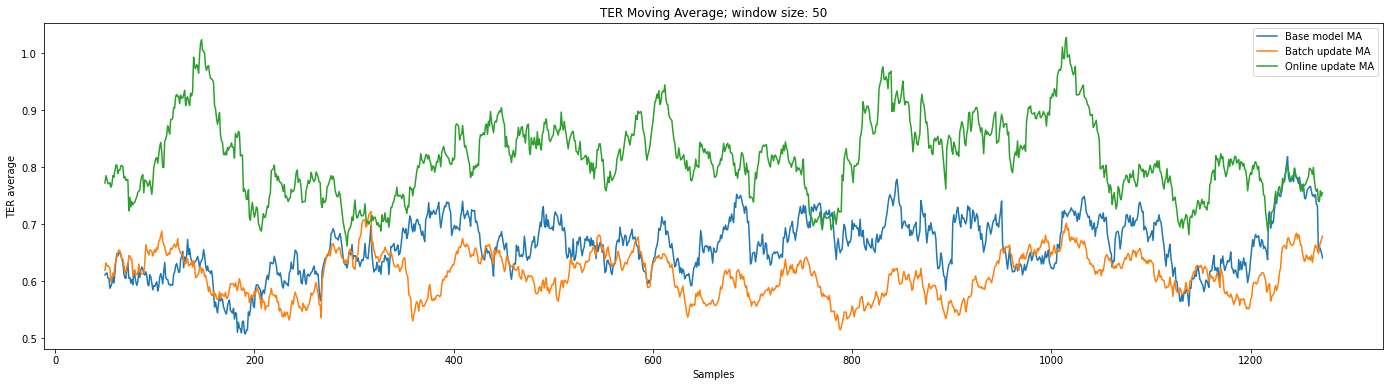

In [ ]:
  import matplotlib.pyplot as plt

  baseline_average.plot( figsize= (24,6), title= f'TER Moving Average; window size: {window_size}', label='Base model MA', xlabel= 'Samples',ylabel='TER average',legend=True )
  batch_average.plot(label= 'Batch update MA', legend=True)
  online_average.plot(label='Online update MA' ,legend=True)

## Conclusion
From the graph plot, the online model had the worst TER moving average in the long run. The baseline model and batch update model seem to be competing though the batch updated model seem to generally have a lower TER moving average signifying that it had a better generalization after training on the development set. This signifies that it had the best generalization during the training process. 

It must be known that a lot of factors were responsible for the differences in performance between this model and the research paper and some include:

- Different number of neurons,dropouts in the model's architecture: We used lesser here because of RAM space. For the dropouts, we followed a general scheme of 20% dropout.

- Different dataset: The model here was trained on about 10000 samples while that in the research was pretrained on 6.6M.

- Different environmental variables in the online training mode: threshold level for cosine similarity, number of epochs and learning rate for model update on instance selection datapoints, number of epochs and learning rate for model update on each development set datapoint.